In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

# 1. Hyper-parameters and Dataset

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/PyTorch/Github_Series/03-advanced/'

# sample_dir = data_dir+'samples'
# # Create a directory if not exists
# if not os.path.exists(sample_dir):
#   os.makedirs(sample_dir)

Mounted at /content/drive


In [4]:
# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# data loader
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

# 2. Modeling and Training

## 2.1 Background - Autoencoder

Autoencoders basically contain two parts: 
<ul>
  <li> the first one is an encoder which is similar to the convolution neural network except for the last layer. The aim of the encoder to learn efficient data encoding from the dataset and pass it into a bottleneck architecture.
  <li> the other part of the autoencoder is a decoder that uses latent space in the bottleneck layer to regenerate the images similar to the dataset.
</ul>

## 2.2 Variational Autoencoder - Modeling

Variational autoencoder is different from autoencoder in a way such that it provides a statistic manner for describing the samples of the dataset in latent space. Therefore, in variational autoencoder, **the encoder outputs a probability distribution in the bottleneck layer** instead of a single output value.

<br>

**Q1. Sigmoid and Binary Cross Entropy**:

Since the input values are in the range [0,1], then it is acceptable to use sigmoid as the activation function of last layer. [More discussion about why use Sigmoid and Binary Cross Entropy loss](https://stackoverflow.com/questions/52441877/how-does-binary-cross-entropy-loss-work-on-autoencoders) 

<br>

**Q2. Reparameterization**
![VAE diagram](https://www.baeldung.com/wp-content/uploads/sites/4/2022/03/LionVAE.png "VAE diagram")

The VAE predicts the parameters of a distribution which then is used to generate encoded embeddings. This process of sampling from a distribution that is parameterized by our model is not differentiable. If something is not differentiable that is a problem, at least for gradient-based approaches. We can solve this problem by applying the **reparameterization trick** to our embedding function.

![Compare "without reparameterization" vs. "with reparameterization"](https://www.baeldung.com/wp-content/ql-cache/quicklatex.com-43bec312dfd1aec6ca039e640645b516_l3.svg "Compare 'without reparameterization' vs. 'with reparameterization'")

When z is sampled stochastically from a parameterized distribution we see that all our gradients would have to flow through the stochastic node. In contrast, reparameterization allows a gradient path through a non-stochastic node. **We relegate the random sampling to a noise vector which effectively separates it from the gradient flow.**

<br>

**Q3. Why log variance instead of directly standard deviation.**

We need to make sure our model **outputs a positive number for the variance**, and modeling the log-variance was the easiest way with the tools in our toolbox. [More discussion about why log-variance](https://stats.stackexchange.com/questions/455560/why-is-the-mean-and-log-variance-specified-as-the-output-of-an-inference-network)

<br>

**Q4. KL divergence**

KL divergence stands for Kullback Leibler Divergence, it is a measure of divergence between two distributions. In the context of VAE, the purpose of the KL divergence term in the loss function is to make the distribution of the encoder output as close as possible to a standard multivariate normal distribution. [The proof of the KL divergence formula](https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes)


In [5]:
class VAE(nn.Module):

  def __init__(self, image_size=784, h_dim=400, z_dim=20):
    super(VAE, self).__init__()
    # Build encoder
    self.encoder = nn.Sequential(
        nn.Linear(image_size, h_dim),
        nn.ReLU()
    )
    self.fc_mu = nn.Linear(h_dim, z_dim)
    self.fc_var = nn.Linear(h_dim, z_dim)
    
    # Build decoder
    self.decoder = nn.Sequential(
        nn.Linear(z_dim, h_dim),
        nn.ReLU(),
        nn.Linear(h_dim, image_size),
        nn.Sigmoid()
    )

  def __encode(self, x):
    h = self.encoder(x)
    return self.fc_mu(h), self.fc_var(h)

  def __reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + torch.mul(std, eps) 

  def __decode(self, z):
    return self.decoder(z)

  def forward(self, x):
    mu, log_var = self.__encode(x)
    z = self.__reparameterize(mu, log_var)
    x_reconst = self.__decode(z)
    return x_reconst, mu, log_var

## 2.2 Test the architecture of the VAE model

In [6]:
# Test the model architecture 
model = VAE().to(device)
test_image = iter(data_loader).next()[0][0]
input = test_image.view(-1, image_size).to(device)
print('Input size:', input.shape)

# Test the output of encoder
mu, log_var = model._VAE__encode(input)   # Call the private member through name mangling
print('mu size: {}, log_var size: {}'.format(mu.shape, log_var.shape))
assert mu.shape == (1, z_dim)
assert log_var.shape == (1, z_dim)

# Test the output after reparameterization
z = model._VAE__reparameterize(mu, log_var)
print('sampled latent vector z size: {}'.format(z.shape))
assert z.shape == (1, z_dim)

# Test the output of decoder
output = model._VAE__decode(z)
print('Reconstructed image size:', output.shape)
assert output.shape == (1, image_size)

Input size: torch.Size([1, 784])
mu size: torch.Size([1, 20]), log_var size: torch.Size([1, 20])
sampled latent vector z size: torch.Size([1, 20])
Reconstructed image size: torch.Size([1, 784])


## 2.3 Train the model

In [7]:
# Train the model
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(data_loader)
loss_re_arr, loss_kl_arr, loss_arr = [], [], []

for epoch in range(num_epochs):
  for batch_id, (images, labels) in enumerate(data_loader):
    input = images.view(-1, image_size).to(device)
    
    # Forward
    x_reconst, mu, log_var = model.forward(input)
    
    # Compute reconstruction loss and kl divergence
    reconst_loss = F.binary_cross_entropy(x_reconst, input, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    loss = reconst_loss + kl_div

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (batch_id+1) % 100 == 0:
      print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Reconstruction Loss: {:.4f}, KL-divergence Loss: {:.4f}'
            .format(epoch+1, num_epochs, batch_id+1, total_step, loss, reconst_loss, kl_div))
      
    loss_re_arr.append(reconst_loss.item())
    loss_kl_arr.append(kl_div.item())
    loss_arr.append(loss.item())

Epoch: [1/15], Step: [100/469], Loss: 24225.1074, Reconstruction Loss: 22768.7812, KL-divergence Loss: 1456.3254
Epoch: [1/15], Step: [200/469], Loss: 19015.3887, Reconstruction Loss: 17044.2520, KL-divergence Loss: 1971.1365
Epoch: [1/15], Step: [300/469], Loss: 17926.3086, Reconstruction Loss: 15773.6055, KL-divergence Loss: 2152.7041
Epoch: [1/15], Step: [400/469], Loss: 17260.8223, Reconstruction Loss: 14746.7559, KL-divergence Loss: 2514.0659
Epoch: [2/15], Step: [100/469], Loss: 16274.7070, Reconstruction Loss: 13576.8535, KL-divergence Loss: 2697.8530
Epoch: [2/15], Step: [200/469], Loss: 15407.1221, Reconstruction Loss: 12636.6367, KL-divergence Loss: 2770.4854
Epoch: [2/15], Step: [300/469], Loss: 15168.3965, Reconstruction Loss: 12308.0723, KL-divergence Loss: 2860.3247
Epoch: [2/15], Step: [400/469], Loss: 14806.5938, Reconstruction Loss: 11965.5732, KL-divergence Loss: 2841.0210
Epoch: [3/15], Step: [100/469], Loss: 14867.7451, Reconstruction Loss: 11848.3027, KL-divergence

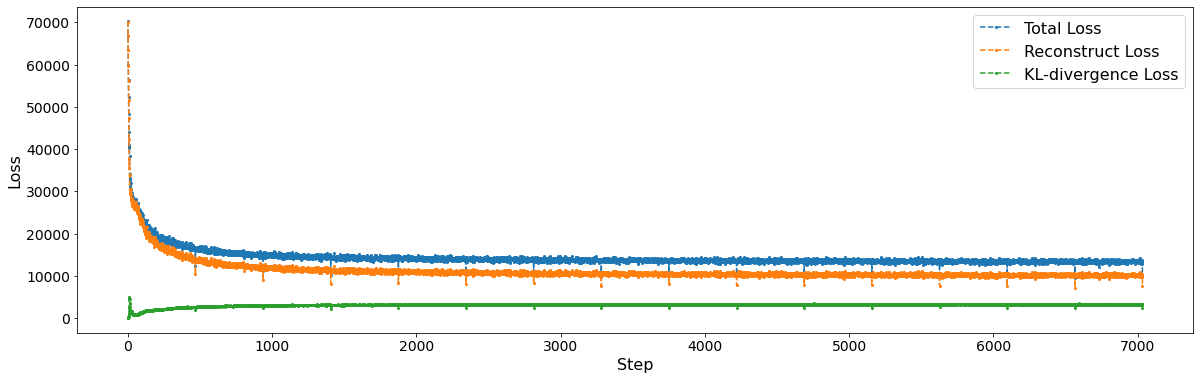

In [8]:
plt.figure(figsize=(20,6))
plt.plot(loss_arr, '--', marker='o', markersize=2, label='Total Loss')
plt.plot(loss_re_arr, '--', marker='o', markersize=2, label='Reconstruct Loss')
plt.plot(loss_kl_arr, '--', marker='o', markersize=2, label='KL-divergence Loss')
plt.xlabel('Step', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=16)
plt.show()